In [1]:
from src.Dataset import getDataLoader
import torch
from src.utils import *

In [2]:
classes = ["4ask","8pam","16psk","32qam_cross","2fsk","ofdm-256"]
iq_samples = 1024
samples_per_class= 1000
batch_size = 32
epochs = 10
eff_net_PATH = f'src/SavedModels/efficientNet_epochs_{epochs}.pt'
in_channels = 2

dl_train, ds_train, dl_test, ds_test, dl_val, ds_val = getDataLoader(
    classes = classes,
    iq_samples = iq_samples,
    samples_per_class= samples_per_class,
    batch_size=batch_size
    )

In [3]:
ds_train[0][0].shape

(2, 1024)

In [4]:
next(iter(dl_train))[0].shape

torch.Size([32, 2, 1024])

In [5]:
vqvae_model = torch.load('src/SavedModels/VQVAE_epochs_10.pt').to(device)

/tmp/ipykernel_236087/3239689431.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vqvae_model = torch.load('src/SavedModels/VQVAE_epochs_10.pt').to(device)


In [6]:
test_data = torch.cat([torch.cat((label.unsqueeze(1).to(device), vqvae_model.codebook.quantize_indices(vqvae_model.encode(x.to(device)))), dim=1) for x, label in dl_test],dim=0)

In [8]:
model_transformer = torch.load('src/SavedModels/MonaiTransformer_epochs_10.pt').to(device)
#model_transformer = torch.load('src/SavedModels/Transformer_epochs_10.pt').to(device)

/tmp/ipykernel_236087/3371109386.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_transformer = torch.load('src/SavedModels/MonaiTransformer_epochs_10.pt').to(devic

In [40]:
context = torch.tensor([[3]*4]).to(device)
sample1 = model_transformer.generate(context, max_new_tokens=512)
sample2 = model_transformer.generate(context, max_new_tokens=512)

In [38]:
print(sample1[:,:15])
print(sample2[:,:15])

tensor([[ 3,  3,  3,  3, 58,  4, 29, 33, 55, 11, 59, 29,  5,  5, 42]],
       device='cuda:1')
tensor([[ 3,  3,  3,  3, 59,  2, 25, 25, 23, 60, 45, 45, 63, 27, 11]],
       device='cuda:1')


In [10]:
difference = sample1 == sample2 # Element-wise comparison
print("Element-wise comparison result:")
print(difference)

if torch.all(difference):
    print("The tensors are exactly the same.")
else:
    print("The tensors are different.")


Element-wise comparison result:
tensor([[ True, False, False,  True, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
          True, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, Fals

In [47]:
import os
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision import transforms
from tqdm import tqdm  
from src.VQVAE import *
from src.utils import *
from src.Transformer import TransformerModel
from src.TransformerMonai import MonaiDecoderOnlyModel
from src.Dataset import getDataLoader
import matplotlib.pyplot as plot
import numpy as np

from top_pr import compute_top_pr as TopPR


# Define the classes
classes = ["4ask", "8pam", "16psk", "32qam_cross", "2fsk", "ofdm-256"]

# Load models
VQVAE = torch.load(VQVAE_PATH).to(device)
VQVAE.eval()  
modelTransformer = torch.load(MONAI_TRANSFORMER_MODEL_PATH).to(device)
modelTransformer.eval()
modelGPT2 = torch.load(TRANSFORMER_MODEL_PATH).to(device)
modelGPT2.eval()

# Load data
train_dl, ds_train, test_dl, ds_test, val_dl, ds_val = getDataLoader(
    classes=classes,
    iq_samples=iq_samples,
    samples_per_class=samples_per_class,
    batch_size=4
)

/tmp/ipykernel_236087/729103989.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  VQVAE = torch.load(VQVAE_PATH).to(device)
/tmp/ipykernel_236087/729103989.py:24: FutureW

In [48]:
from Evaluate_models import generate_fake_dataset
GPT2_Histograms_Path = "EvaluationResults/GPT2_results/CodebookHistograms/" 
MONAI_Histograms_Path = "EvaluationResults/Monai_results/CodebookHistograms/" 

real_dataset_path = "src/Saved_datasets/real_dataset.npy"  
fake_dataset_path_GPT2 = "src/Saved_datasets/fake_dataset_transformerGPT2.npy" 
fake_dataset_path_MONAI = "src/Saved_datasets/fake_dataset_transformerMONAI.npy" 
# Save ds_train as a NumPy array
#save_torch_dataset_as_numpy(ds_train, real_dataset_path)

fake_indices_GPT2 = generate_fake_dataset(
    transformer_model=modelGPT2,
    vqvae_model=VQVAE,
    output_file=fake_dataset_path_GPT2,
    num_labels=6,
    samples_per_label=1000,
    signal_length=1024
    )

Generating data for label 0...


100%|██████████| 20/20 [04:27<00:00, 13.37s/it]


Generating data for label 1...


100%|██████████| 20/20 [04:27<00:00, 13.37s/it]


Generating data for label 2...


100%|██████████| 20/20 [04:27<00:00, 13.38s/it]


Generating data for label 3...


100%|██████████| 20/20 [04:27<00:00, 13.37s/it]


Generating data for label 4...


100%|██████████| 20/20 [04:27<00:00, 13.37s/it]


Generating data for label 5...


100%|██████████| 20/20 [04:27<00:00, 13.38s/it]

Generated dataset shape: (6000, 2048)


PermissionError: [Errno 13] Permission denied: 'src/Saved_datasets/fake_dataset_transformerGPT2.npy'

In [49]:
fake_indices_GPT2[0].shape

NameError: name 'fake_indices_GPT2' is not defined

In [12]:
import torch
import matplotlib.pyplot as plt

# Original list of tensors (example setup)
l = []
first_dim = 2
last_dim = 4
for i in range(6):
    for j in range(5):
        k = torch.randint(0, 128, [2, 4])
        l.append(k)

# Stack all tensors
stacked_tensor = torch.cat(l)

# Calculate the intermediate dimension
total_elements = stacked_tensor.numel()
intermediate_dim = total_elements // (first_dim * last_dim)

# Reshape into [first_dim, intermediate_dim, last_dim]
reshaped_tensor = stacked_tensor.reshape(first_dim, intermediate_dim, last_dim)



In [15]:
l

[tensor([[ 88, 107,   5,  26],
         [ 53,  79,  40,  19]]),
 tensor([[ 66,  30,  67, 109],
         [ 26,  17,  63,  86]]),
 tensor([[13, 33, 89, 34],
         [73,  4, 44, 13]]),
 tensor([[ 26,  33,  44,  50],
         [ 93, 124,  35,  52]]),
 tensor([[  1,  52,   9,  61],
         [ 88,  85,  16, 107]]),
 tensor([[ 82,  28, 120,  77],
         [ 26,  82,  70,  93]]),
 tensor([[ 49,  26,  61, 115],
         [ 84,  99,  64,  76]]),
 tensor([[121,  85,  22,  24],
         [  6,  12,  81, 124]]),
 tensor([[ 73, 120,  38,  27],
         [ 53,  41,  58,  54]]),
 tensor([[  2,  10, 100, 120],
         [ 39,  67,  94,  44]]),
 tensor([[ 18, 109,  64,  66],
         [ 40,  54,  34, 119]]),
 tensor([[ 57,  45,  93,   8],
         [118,  58,  49,  86]]),
 tensor([[70, 35, 50, 48],
         [76, 69, 71, 49]]),
 tensor([[ 50, 101,  10,  69],
         [ 82,   9, 113, 124]]),
 tensor([[ 67,  46,  54, 113],
         [ 80,  13,  37,  82]]),
 tensor([[ 10,  63,  12, 115],
         [ 54,  27, 120, 

In [14]:
stacked_tensor

tensor([[ 88, 107,   5,  26],
        [ 53,  79,  40,  19],
        [ 66,  30,  67, 109],
        [ 26,  17,  63,  86],
        [ 13,  33,  89,  34],
        [ 73,   4,  44,  13],
        [ 26,  33,  44,  50],
        [ 93, 124,  35,  52],
        [  1,  52,   9,  61],
        [ 88,  85,  16, 107],
        [ 82,  28, 120,  77],
        [ 26,  82,  70,  93],
        [ 49,  26,  61, 115],
        [ 84,  99,  64,  76],
        [121,  85,  22,  24],
        [  6,  12,  81, 124],
        [ 73, 120,  38,  27],
        [ 53,  41,  58,  54],
        [  2,  10, 100, 120],
        [ 39,  67,  94,  44],
        [ 18, 109,  64,  66],
        [ 40,  54,  34, 119],
        [ 57,  45,  93,   8],
        [118,  58,  49,  86],
        [ 70,  35,  50,  48],
        [ 76,  69,  71,  49],
        [ 50, 101,  10,  69],
        [ 82,   9, 113, 124],
        [ 67,  46,  54, 113],
        [ 80,  13,  37,  82],
        [ 10,  63,  12, 115],
        [ 54,  27, 120,  37],
        [124,  67, 108,  29],
        [ 

In [13]:
reshaped_tensor

tensor([[[ 88, 107,   5,  26],
         [ 53,  79,  40,  19],
         [ 66,  30,  67, 109],
         [ 26,  17,  63,  86],
         [ 13,  33,  89,  34],
         [ 73,   4,  44,  13],
         [ 26,  33,  44,  50],
         [ 93, 124,  35,  52],
         [  1,  52,   9,  61],
         [ 88,  85,  16, 107],
         [ 82,  28, 120,  77],
         [ 26,  82,  70,  93],
         [ 49,  26,  61, 115],
         [ 84,  99,  64,  76],
         [121,  85,  22,  24],
         [  6,  12,  81, 124],
         [ 73, 120,  38,  27],
         [ 53,  41,  58,  54],
         [  2,  10, 100, 120],
         [ 39,  67,  94,  44],
         [ 18, 109,  64,  66],
         [ 40,  54,  34, 119],
         [ 57,  45,  93,   8],
         [118,  58,  49,  86],
         [ 70,  35,  50,  48],
         [ 76,  69,  71,  49],
         [ 50, 101,  10,  69],
         [ 82,   9, 113, 124],
         [ 67,  46,  54, 113],
         [ 80,  13,  37,  82]],

        [[ 10,  63,  12, 115],
         [ 54,  27, 120,  37],
      

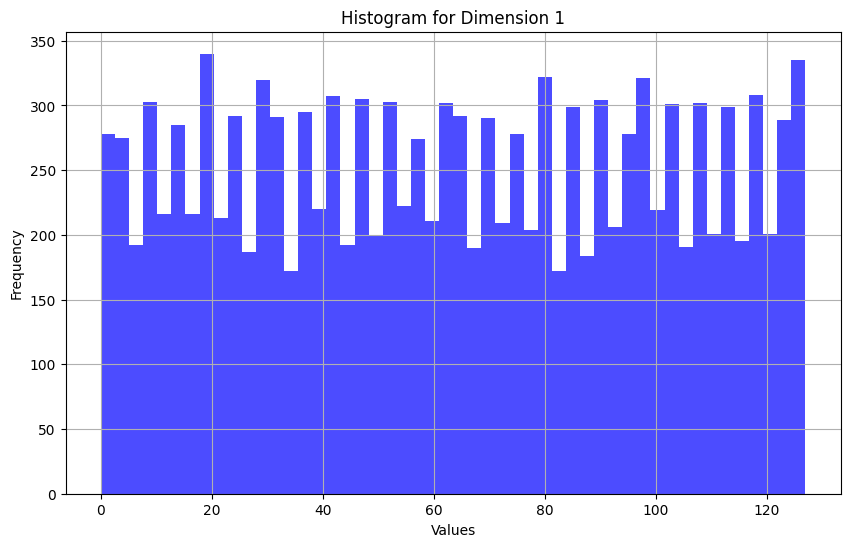

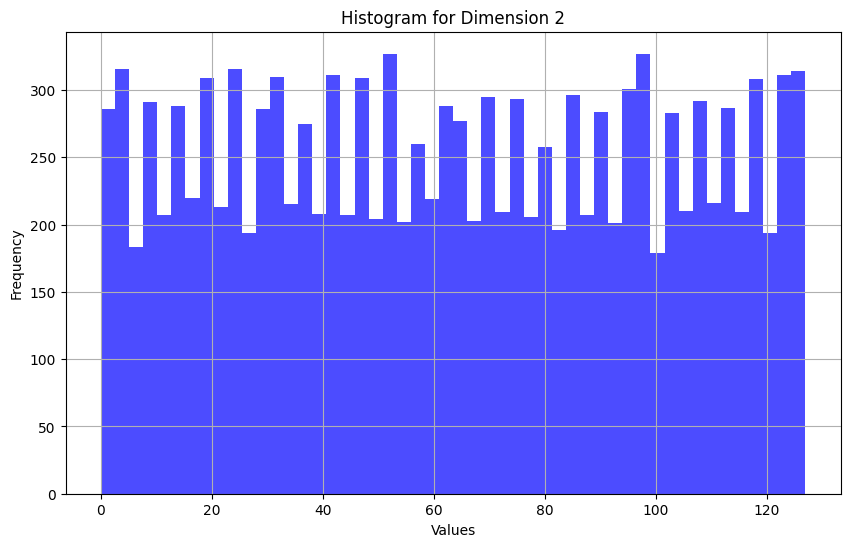

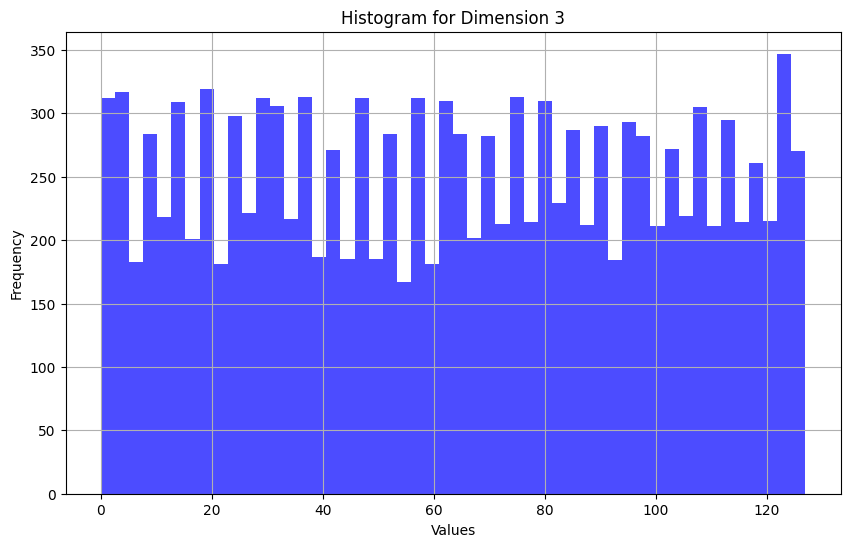

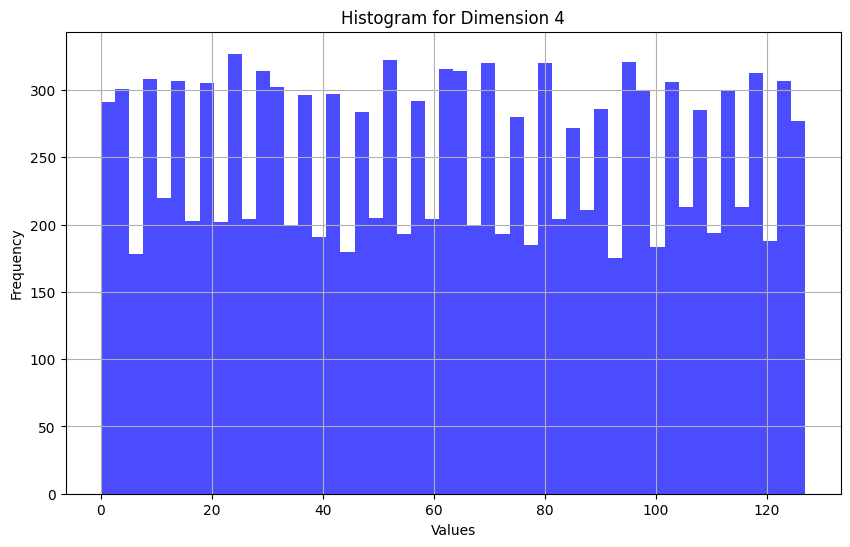

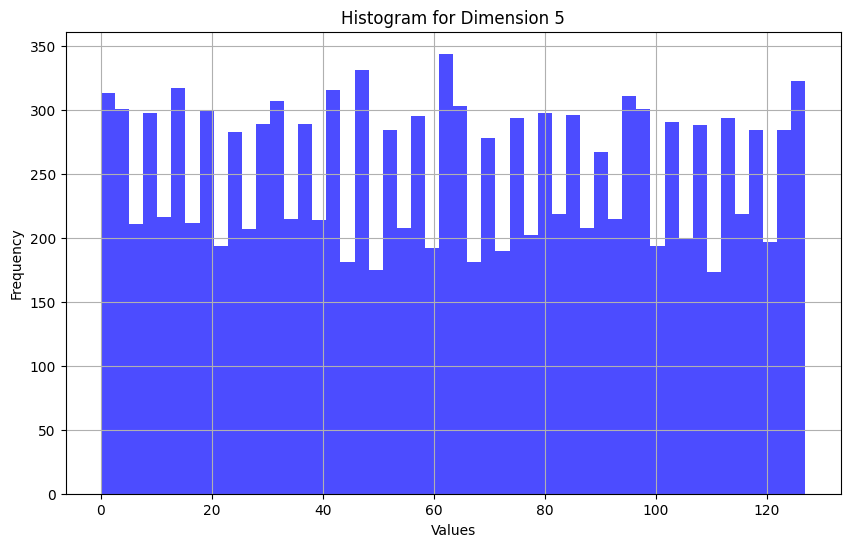

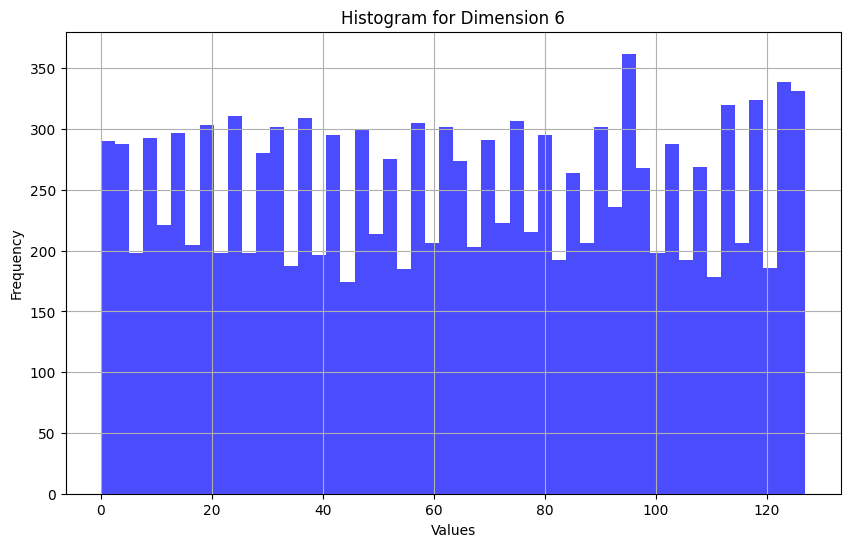

In [11]:

# Plot histograms for each first dimension
for i in range(reshaped_tensor.shape[0]):
    data = reshaped_tensor[i].flatten().numpy()  # Flatten the inner dimensions for histogram
    plt.figure(figsize=(10, 6))
    plt.hist(data, bins=50, color='blue', alpha=0.7)
    plt.title(f'Histogram for Dimension {i+1}')
    plt.xlabel('Values')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

512